In [16]:
from sys import path
path.append('../tools')
from tools import gen_inputs_outputs
from tensorflow import keras
from keras import layers, Sequential, Input, metrics
import matplotlib.pyplot as plt

In [2]:
# We start with two bit calculations
R = 4
x_train, y_train, S = gen_inputs_outputs(R)

In [46]:
# Create the network
model = Sequential([
    Input((R,), name='input_layer'),
    layers.Dense(32, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(S, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[metrics.BinaryAccuracy(threshold=0.5)])

# Training parameters
EPOCHS = 170
BATCH_SIZE = None

history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step - binary_accuracy: 0.5417 - loss: 0.7316
Epoch 2/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5625 - loss: 0.7293
Epoch 3/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5625 - loss: 0.7270
Epoch 4/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5625 - loss: 0.7248
Epoch 5/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5625 - loss: 0.7228
Epoch 6/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5625 - loss: 0.7208
Epoch 7/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5625 - loss: 0.7190
Epoch 8/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5625 - loss: 0.7171
Epoch 9/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.5833 - loss: 0.7153
Epoch 10/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5833 - loss: 0.7135
Epoch 11/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5833 - loss: 0.7

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6250 - loss: 0.6530
Epoch 67/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6250 - loss: 0.6523
Epoch 68/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6250 - loss: 0.6515
Epoch 69/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6250 - loss: 0.6507
Epoch 70/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6250 - loss: 0.6499
Epoch 71/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6250 - loss: 0.6491
Epoch 72/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6250 - loss: 0.6484
Epoch 73/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6250 - loss: 0.6475
Epoch 74/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6250 - loss: 0.6468
Epoch 75/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6250 - loss: 0.6460
Epoch 76/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6250 - loss: 0.6451
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6458 - loss: 0.6005
Epoch 131/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6458 - loss: 0.5996
Epoch 132/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6458 - loss: 0.5986
Epoch 133/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6458 - loss: 0.5978
Epoch 134/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6667 - loss: 0.5969
Epoch 135/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6667 - loss: 0.5960
Epoch 136/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6667 - loss: 0.5951
Epoch 137/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6667 - loss: 0.5942
Epoch 138/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6667 - loss: 0.5933
Epoch 139/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6667 - loss: 0.5924
Epoch 140/170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6667 - loss

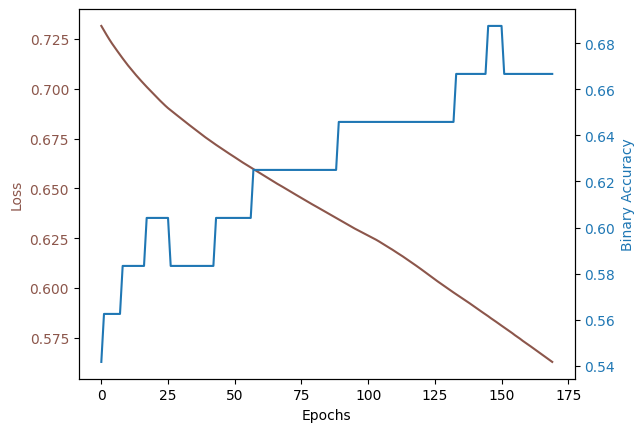

In [47]:
# Plot the results
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')

color1 = 'tab:brown'
ax1.set_ylabel('Loss', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.plot(history.history['loss'], color=color1)

color2 = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('Binary Accuracy', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.plot(history.history['binary_accuracy'], color=color2)

plt.show()